In [1]:
import pandas as pd
pd.set_option('max_colwidth', 100)
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from numpy import *
import scipy.stats as st

In [ ]:
# Data - HBN
# Reported - clinicians 
# Hypothesis - 2a (depression vs no depression but with ADHD/anxiety)
# Note we don't have a hyp 2b for HBN data

In [2]:
path_to_consensusfile = 'data/9994_ConsensusDx_20210310.csv'
path_to_demosfile = 'data/9994_Basic_Demos_20210310.csv'
path_to_cbclfile = 'data/9994_CBCL_20210310.csv'

consensusfile = pd.read_csv(path_to_consensusfile, sep=',', header=0, low_memory=False)
demosfile = pd.read_csv(path_to_demosfile, sep=',', header=0, low_memory=False)
cbclfile = pd.read_csv(path_to_cbclfile, sep=',', header=0, low_memory=False)

print(consensusfile.shape)
print(demosfile.shape)
print(cbclfile.shape)

(6183, 161)
(3634, 15)
(3099, 157)


## 1. Preparing consensusfile and demosfile

In [3]:
names_columns = consensusfile.loc[0].to_dict()
consensusfile = consensusfile.drop(0)
#consensusfile.head()

In [4]:
names_columns_demos = demosfile.loc[0].to_dict()
demosfile = demosfile.drop(0)
#demosfile.head()

In [5]:
# We know that if we merge consensusfile and demosfile now, we will get some meaningless stuff
# Demosfile - look at duplicated rows

dupl = demosfile.duplicated(subset=['EID'])
dupl_frame = dupl.to_frame()
dupl_frame.columns = ['TrueOrFalse']

dupl2 = dupl_frame.groupby(['TrueOrFalse'])['TrueOrFalse'].count()
print(dupl2)

result_df= dupl_frame.loc[dupl_frame['TrueOrFalse']==True]
print(result_df)

TrueOrFalse
False    3628
True        5
Name: TrueOrFalse, dtype: int64
      TrueOrFalse
1829         True
1836         True
1841         True
2971         True
3162         True


In [6]:
# identifyinf EID of repeated items
# take rows which had "true" in the result_df file
# look them up in the demosfile

print(demosfile.loc[[1829]]) # EID = NDAREN522YEV
print(demosfile.loc[[1836]]) # EID = NDARRG499ZWN
print(demosfile.loc[[1841]]) # EID = NDARDD394RRX
print(demosfile.loc[[2971]]) # EID = NDARPF042DD2
print(demosfile.loc[[3162]]) # EID = NDARPL406KX4

     Anonymized ID Subject Type Visit Days since enrollment           EID  \
1829     A00093293      UNKNOWN    V1                     0  NDAREN522YEV   

                START_DATE    Patient_ID Enrollment Year Enrollment Season  \
1829  1901-01-01T07:00:00Z  NDAREN522YEV            2017            Summer   

     Sex        Age Study Site Commercial Use Release Number  \
1829   0  16.992242          1            Yes              6   

     Participant_Status  
1829  Lost to follow-up  
     Anonymized ID Subject Type Visit Days since enrollment           EID  \
1836     A00093300      UNKNOWN    V1                     0  NDARRG499ZWN   

                START_DATE    Patient_ID Enrollment Year Enrollment Season  \
1836  1901-01-01T07:00:00Z  NDARRG499ZWN            2017            Summer   

     Sex       Age Study Site Commercial Use Release Number Participant_Status  
1836   0  7.472621          1            Yes              6  Lost to follow-up  
     Anonymized ID Subject Type V

In [7]:
x= demosfile.loc[demosfile['EID']=='NDAREN522YEV']
x

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
1094,A00087369,UNKNOWN,V1,0,NDAREN522YEV,1901-01-01T07:00:00Z,NDAREN522YEV,2017,Summer,0,16.992242,1,Yes,3,Lost to follow-up
1829,A00093293,UNKNOWN,V1,0,NDAREN522YEV,1901-01-01T07:00:00Z,NDAREN522YEV,2017,Summer,0,16.992242,1,Yes,6,Lost to follow-up


In [8]:
x= demosfile.loc[demosfile['EID']=='NDARRG499ZWN']
x

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
188,A00079051,UNKNOWN,V1,0,NDARRG499ZWN,1901-01-01T07:00:00Z,NDARRG499ZWN,2017,Summer,0,7.472621,1,Yes,2,NaN
1836,A00093300,UNKNOWN,V1,0,NDARRG499ZWN,1901-01-01T07:00:00Z,NDARRG499ZWN,2017,Summer,0,7.472621,1,Yes,6,Lost to follow-up


In [9]:
x= demosfile.loc[demosfile['EID']=='NDARDD394RRX']
x

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
1133,A00087408,UNKNOWN,V1,0,NDARDD394RRX,1901-01-01T07:00:00Z,NDARDD394RRX,2017,Fall,0,6.033196,1,Yes,3,Dropout
1841,A00093305,UNKNOWN,V1,0,NDARDD394RRX,1901-01-01T07:00:00Z,NDARDD394RRX,2017,Fall,0,6.033196,1,Yes,6,Dropout


In [10]:
x= demosfile.loc[demosfile['EID']=='NDARPF042DD2']
x

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
2520,A00097035,UNKNOWN,V1,0,NDARPF042DD2,1901-01-01T07:00:00Z,NDARPF042DD2,2018,Winter,0,6.221537,1,Yes,7,Dropout
2971,A00101808,UNKNOWN,V1,0,NDARPF042DD2,1901-01-01T07:00:00Z,NDARPF042DD2,2018,Winter,0,6.221537,1,Yes,9,Complete


In [11]:
x= demosfile.loc[demosfile['EID']=='NDARPL406KX4']
x

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
990,A00087265,UNKNOWN,V1,0,NDARPL406KX4,1901-01-01T07:00:00Z,NDARPL406KX4,2017,Spring,0,8.67237,1,Yes,3,Lost to follow-up
3162,A00101999,UNKNOWN,V1,0,NDARPL406KX4,1901-01-01T07:00:00Z,NDARPL406KX4,2019,Spring,0,10.719826,1,Yes,9,Complete


In [12]:
# let's just drop repeated rows in the second file
# EID = NDAREN522YEV: Rows are identical except release number. Drop the first one (release 3)
# --> drop row id 1094
# EID = NDARRG499ZWN: Rows are identical except for partiipant status (release 6: lost to follow up). Keeping row 2
# --> drop row id 1836
# EID = NDARDD394RRX Rows are identical except release number. drop the first one (release 3)
# --> drop row id 1133
# EID = NDARPF042DD2 Participant status differens. Keeping the second row where the status is complete
# --> drop row 2520
# EID = NDARPL406KX4 Participant status differs. Keeping row 2 where the status is complete
# --> drop row 990

demosfile = demosfile.drop([990, 1094, 1133, 1836, 2520])
demosfile.shape

(3628, 15)

### Now we can merge consensusfile and demosfile (but we still have some cleaning to do because consensusfile had repeated rows)

In [13]:
consensus_and_demos_2 = pd.merge(consensusfile, demosfile, on='EID', indicator=True)

In [14]:
print(consensusfile.nunique())
print('\n')
print(demosfile.nunique())
print('\n')
print(consensus_and_demos_2.nunique())

Anonymized ID            3617
Subject Type                1
Visit                       1
Days since enrollment       1
EID                      3615
                         ... 
DX_10_ByHx                  2
DX_10_New                   1
DX_10_Rem                   1
DX_10_PRem                  1
DX_10_Past_Doc              1
Length: 161, dtype: int64


Anonymized ID            3628
Subject Type                1
Visit                       1
Days since enrollment       1
EID                      3628
START_DATE                  1
Patient_ID               3628
Enrollment Year             6
Enrollment Season           4
Sex                         2
Age                      3312
Study Site                  5
Commercial Use              2
Release Number              9
Participant_Status          3
dtype: int64


Anonymized ID_x            3617
Subject Type_x                1
Visit_x                       1
Days since enrollment_x       1
EID                        3615
                 

consensusfile: Anonymized ID = 3617, EID = 3615 <br>
demosfile: Anonymized ID = 3628, EID = 3628 <br>
consensus_and_demos_2: Anonymized ID = 3617, EID = 3615 <br>
<br>
Was before removing duplicates in demosfile:
.nunique results: <br>
--> consensusfile: 3615 <br>
--> demosfile: 3628 <br>
--> consensus_and_demos: 3615 <br>

In [15]:
# checking where repeated rows ends

print(consensus_and_demos_2.loc[[5136]])
print('\n')
print(consensus_and_demos_2.loc[[5137]])
print('\n')
print(consensus_and_demos_2.loc[[5138]])

     Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
5136       A00097094        UNKNOWN      V1                       0   

               EID          START_DATE_x Study Site  Year  Season  ...  \
5136  NDARPA265JGD  1901-01-01T07:00:00Z   HBN    1  2019  Spring  ...   

        Patient_ID Enrollment Year Enrollment Season Sex        Age  \
5136  NDARPA265JGD            2019            Spring   0  11.368697   

     Study Site Commercial Use Release Number Participant_Status _merge  
5136          1            Yes              7            Dropout   both  

[1 rows x 176 columns]


     Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
5137       A00097094        UNKNOWN      V1                       0   

               EID          START_DATE_x Study Site  Year  Season  ...  \
5137  NDARPA265JGD  1901-01-01T07:00:00Z   HBN    1  2019  Spring  ...   

        Patient_ID Enrollment Year Enrollment Season Sex        Age  \
5137  NDARPA265JGD          

### Splitting the file up until the last repeated row. After splitting, only keep the even rows in the first part. Keep all rows in the 2nd part (there are no reppetitions there)

In [16]:
consensus_and_demos_2 = consensus_and_demos_2.reset_index(drop=True)

In [17]:
consensus_and_demos_2_part1 = consensus_and_demos_2.loc[:5136]
consensus_and_demos_2_part1.shape

(5137, 176)

In [18]:
consensus_and_demos_2_part1_evens = consensus_and_demos_2_part1.iloc[::2, :]
consensus_and_demos_2_part1_evens.shape

(2569, 176)

In [19]:
consensus_and_demos_2_part2 = consensus_and_demos_2.loc[5137:]
consensus_and_demos_2_part2.shape

(1045, 176)

In [20]:
consensus_and_demos_3 = consensus_and_demos_2_part1_evens.append(consensus_and_demos_2_part2, ignore_index=True)
consensus_and_demos_3.shape

(3614, 176)

In [21]:
consensus_and_demos_3.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status,_merge
0,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,NDARYM832PX3,2015,Spring,1,7.048254,1,No,1,Complete,both
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,NDARNJ687DMC,2015,Spring,1,6.348163,1,No,1,Complete,both
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,NDARRM363BXZ,2015,Spring,0,10.052589,1,No,1,Dropout,both
3,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,NDARUW586LLL,2015,Spring,1,12.319415,1,No,1,Complete,both
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,NDARDC298NW4,2015,Spring,0,13.901437,1,No,1,Complete,both


In [23]:
print(consensusfile.shape)
consensusfile = consensusfile.reset_index(drop=True)
consensusfile_part1 = consensusfile.loc[:5136]
print(consensusfile_part1.shape)
print(consensusfile_part1.loc[5136])

(6182, 161)
(5137, 161)
Anonymized ID               A00098028
Subject Type                  UNKNOWN
Visit                              V1
Days since enrollment               0
EID                      NDARTR157NPQ
                             ...     
DX_10_ByHx                        NaN
DX_10_New                         NaN
DX_10_Rem                         NaN
DX_10_PRem                        NaN
DX_10_Past_Doc                    NaN
Name: 5136, Length: 161, dtype: object


In [24]:
consensusfile_part1_evens = consensusfile_part1.iloc[::2, :]
print(consensusfile_part1_evens.shape)

consensusfile_part2 = consensusfile.loc[5137:]
print(consensusfile_part2.shape)

consensusfile_3 = consensusfile_part1_evens.append(consensusfile_part2, ignore_index=True)
print(consensusfile_3.shape)

(2569, 161)
(1045, 161)
(3614, 161)


In [25]:
# First, let's add the indicator column

consensusfile_3['currently_depressed_DX_01'] = ((consensusfile_3.DX_01 == "Major Depressive Disorder") | ((consensusfile_3.DX_01 == "Dysthymia") | (consensusfile_3.DX_01 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_01 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_01 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_01_Rem != 1)
consensusfile_3['currently_depressed_DX_02'] = ((consensusfile_3.DX_02 == "Major Depressive Disorder") | ((consensusfile_3.DX_02 == "Dysthymia") | (consensusfile_3.DX_02 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_02 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_02 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_02_Rem != 1)
consensusfile_3['currently_depressed_DX_03'] = ((consensusfile_3.DX_03 == "Major Depressive Disorder") | ((consensusfile_3.DX_03 == "Dysthymia") | (consensusfile_3.DX_03 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_03 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_03 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_03_Rem != 1)
consensusfile_3['currently_depressed_DX_04'] = ((consensusfile_3.DX_04 == "Major Depressive Disorder") | ((consensusfile_3.DX_04 == "Dysthymia") | (consensusfile_3.DX_04 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_04 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_04 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_04_Rem != 1)
consensusfile_3['currently_depressed_DX_05'] = ((consensusfile_3.DX_05 == "Major Depressive Disorder") | ((consensusfile_3.DX_05 == "Dysthymia") | (consensusfile_3.DX_05 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_05 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_05 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_05_Rem != 1)
consensusfile_3['currently_depressed_DX_06'] = ((consensusfile_3.DX_06 == "Major Depressive Disorder") | ((consensusfile_3.DX_06 == "Dysthymia") | (consensusfile_3.DX_06 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_06 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_06 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_06_Rem != 1)
consensusfile_3['currently_depressed_DX_07'] = ((consensusfile_3.DX_07 == "Major Depressive Disorder") | ((consensusfile_3.DX_07 == "Dysthymia") | (consensusfile_3.DX_07 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_07 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_07 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_07_Rem != 1)
consensusfile_3['currently_depressed_DX_08'] = ((consensusfile_3.DX_08 == "Major Depressive Disorder") | ((consensusfile_3.DX_08 == "Dysthymia") | (consensusfile_3.DX_08 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_08 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_08 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_08_Rem != 1)
consensusfile_3['currently_depressed_DX_09'] = ((consensusfile_3.DX_09 == "Major Depressive Disorder") | ((consensusfile_3.DX_09 == "Dysthymia") | (consensusfile_3.DX_09 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_09 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_09 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_09_Rem != 1)
consensusfile_3['currently_depressed_DX_10'] = ((consensusfile_3.DX_10 == "Major Depressive Disorder") | ((consensusfile_3.DX_10 == "Dysthymia") | (consensusfile_3.DX_10 == "Persistent Depressive Disorder (Dysthymia)"))  | (consensusfile_3.DX_10 == "Other Specified Depressive Disorder") | (consensusfile_3.DX_10 == "Unspecified Depressive Disorder")) & (consensusfile_3.DX_10_Rem != 1)

consensusfile_3['currently_depressed'] = (consensusfile_3.currently_depressed_DX_01 == True) | (consensusfile_3.currently_depressed_DX_02 == True) | (consensusfile_3.currently_depressed_DX_03 == True) | (consensusfile_3.currently_depressed_DX_04 == True) | (consensusfile_3.currently_depressed_DX_05 == True) | (consensusfile_3.currently_depressed_DX_06 == True) | (consensusfile_3.currently_depressed_DX_07 == True) | (consensusfile_3.currently_depressed_DX_08 == True) | (consensusfile_3.currently_depressed_DX_09 == True) | (consensusfile_3.currently_depressed_DX_10 == True)

consensusfile_3['currently_depressed'].value_counts()

False    3352
True      262
Name: currently_depressed, dtype: int64

In [26]:
demosfile.head()

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,START_DATE,Patient_ID,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status
1,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,NDARYM832PX3,2015,Spring,1,7.048254,1,No,1,Complete
2,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,NDARNJ687DMC,2015,Spring,1,6.348163,1,No,1,Complete
3,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,NDARRM363BXZ,2015,Spring,0,10.052589,1,No,1,Dropout
4,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,NDARUW586LLL,2015,Spring,1,12.319415,1,No,1,Complete
5,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,NDARDC298NW4,2015,Spring,0,13.901437,1,No,1,Complete


In [27]:
# now let's merge
# Demosfile is already clean from our previous efforts

consensus_and_demos_4 = pd.merge(consensusfile_3, demosfile, on='EID', indicator=True)
consensus_and_demos_4.shape

(3614, 187)

In [28]:
# DEPRESSED_9-13 - consensus_and_demos_4

In [29]:
consensus_and_demos_4["depressed_9-13"] = (consensus_and_demos_4.currently_depressed == True) & ((consensus_and_demos_4.Age.astype(float) >= 9.0) & (consensus_and_demos_4.Age.astype(float) <= 13.0))
consensus_and_demos_4["depressed_9-13"].value_counts()

False    3545
True       69
Name: depressed_9-13, dtype: int64

In [30]:
# HEALTHY_9-13 - consensus_and_demos_4

In [31]:
consensus_and_demos_current = consensus_and_demos_4 # this needs claening.........
consensus_and_demos_current.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,Enrollment Year,Enrollment Season,Sex,Age,Study Site,Commercial Use,Release Number,Participant_Status,_merge,depressed_9-13
0,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,2015,Spring,1,7.048254,1,No,1,Complete,both,False
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,2015,Spring,1,6.348163,1,No,1,Complete,both,False
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,2015,Spring,0,10.052589,1,No,1,Dropout,both,False
3,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,2015,Spring,1,12.319415,1,No,1,Complete,both,True
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,2015,Spring,0,13.901437,1,No,1,Complete,both,False


In [32]:
consensus_and_demos_current = consensus_and_demos_current.replace(np.nan, 'Healthy', regex=True)

In [33]:
consensus_and_demos_current['healthy'] = ((consensus_and_demos_current.DX_01 == "No Diagnosis Given") | (consensus_and_demos_current.DX_01 == "Healthy")) & \
(consensus_and_demos_current.DX_02 == "Healthy") & \
(consensus_and_demos_current.DX_03 == "Healthy") & \
(consensus_and_demos_current.DX_04 == "Healthy") & \
(consensus_and_demos_current.DX_05 == "Healthy") & \
(consensus_and_demos_current.DX_06 == "Healthy") & \
(consensus_and_demos_current.DX_07 == "Healthy") & \
(consensus_and_demos_current.DX_08 == "Healthy") & \
(consensus_and_demos_current.DX_09 == "Healthy") & \
(consensus_and_demos_current.DX_10 == "Healthy")

consensus_and_demos_current['healthy'].value_counts()

/tmp/ipykernel_71751/3075718431.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['healthy'] = ((consensus_and_demos_current.DX_01 == "No Diagnosis Given") | (consensus_and_demos_current.DX_01 == "Healthy")) & \


False    3280
True      334
Name: healthy, dtype: int64

In [34]:
consensus_and_demos_current["healthy_9-13"] = (consensus_and_demos_current.healthy == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
print(consensus_and_demos_current["healthy_9-13"].value_counts())

False    3504
True      110
Name: healthy_9-13, dtype: int64


/tmp/ipykernel_71751/2730979134.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current["healthy_9-13"] = (consensus_and_demos_current.healthy == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))


In [1]:
# Here is a long piece of code whwere I encode the anxiety/ADHD diagnoses

In [35]:
consensus_and_demos_current['anxiety_DX_01'] = ((consensus_and_demos_current.DX_01 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_01 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_01 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_01 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_01_Rem != 1))

consensus_and_demos_current['ADHD_DX_01'] = ((consensus_and_demos_current.DX_01 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_01 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_01 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_01 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_01 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_01_Rem != 1))

/tmp/ipykernel_71751/360816232.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_01'] = ((consensus_and_demos_current.DX_01 == "Generalized Anxiety Disorder") | \
/tmp/ipykernel_71751/360816232.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_01'] = ((consensus_and_demos_current.DX_01 == "ADHD-Combined Type") | \


In [36]:
consensus_and_demos_current['anxiety_DX_02'] = ((consensus_and_demos_current.DX_02 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_02 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_02 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_02 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_02_Rem != 1))

consensus_and_demos_current['ADHD_DX_02'] = ((consensus_and_demos_current.DX_02 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_02 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_02 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_02 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_02 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_02_Rem != 1))

/tmp/ipykernel_71751/95007359.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_02'] = ((consensus_and_demos_current.DX_02 == "Generalized Anxiety Disorder") | \
/tmp/ipykernel_71751/95007359.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_02'] = ((consensus_and_demos_current.DX_02 == "ADHD-Combined Type") | \


In [37]:
consensus_and_demos_current['anxiety_DX_03'] = ((consensus_and_demos_current.DX_03 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_03 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_03 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_03 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_03 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_03 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_03_Rem != 1))

consensus_and_demos_current['ADHD_DX_03'] = ((consensus_and_demos_current.DX_03 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_03 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_03 == "ADHD-Hyperactive/Impulsive Type") | \
                                             (consensus_and_demos_current.DX_03 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_03_Rem != 1))

/tmp/ipykernel_71751/4120038952.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_03'] = ((consensus_and_demos_current.DX_03 == "Specific Phobia") | \
/tmp/ipykernel_71751/4120038952.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_03'] = ((consensus_and_demos_current.DX_03 == "ADHD-Inattentive Type") | \


In [38]:
consensus_and_demos_current['anxiety_DX_04'] = ((consensus_and_demos_current.DX_04 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_04 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_04 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_04 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_04 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_04 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_04_Rem != 1))

consensus_and_demos_current['ADHD_DX_04'] = ((consensus_and_demos_current.DX_04 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_04 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_04 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_04_Rem != 1))

/tmp/ipykernel_71751/3910100484.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_04'] = ((consensus_and_demos_current.DX_04 == "Specific Phobia") | \
/tmp/ipykernel_71751/3910100484.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_04'] = ((consensus_and_demos_current.DX_04 == "ADHD-Inattentive Type") | \


In [39]:
consensus_and_demos_current['anxiety_DX_05'] = ((consensus_and_demos_current.DX_05 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_05 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_05 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_05 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_05 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_05 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_05 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_05_Rem != 1))

consensus_and_demos_current['ADHD_DX_05'] = ((consensus_and_demos_current.DX_05 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_05 == "ADHD-Combined Type") | \
                                             (consensus_and_demos_current.DX_05 == "Other Specified Attention-Deficit/Hyperactivity Disorder") & \
                                             (consensus_and_demos_current.DX_05_Rem != 1))

/tmp/ipykernel_71751/1533483867.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_05'] = ((consensus_and_demos_current.DX_05 == "Specific Phobia") | \
/tmp/ipykernel_71751/1533483867.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_05'] = ((consensus_and_demos_current.DX_05 == "ADHD-Inattentive Type") | \


In [40]:
consensus_and_demos_current['anxiety_DX_06'] = ((consensus_and_demos_current.DX_06 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_06 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_06 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_06 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_06 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_06 == "Unspecified Anxiety Disorder") & \
                                                (consensus_and_demos_current.DX_06_Rem != 1))

consensus_and_demos_current['ADHD_DX_06'] = ((consensus_and_demos_current.DX_06 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_06 == "ADHD-Combined Type") & \
                                            (consensus_and_demos_current.DX_06_Rem != 1))

/tmp/ipykernel_71751/3223325898.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_06'] = ((consensus_and_demos_current.DX_06 == "Specific Phobia") | \
/tmp/ipykernel_71751/3223325898.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_06'] = ((consensus_and_demos_current.DX_06 == "ADHD-Inattentive Type") | \


In [41]:
consensus_and_demos_current['anxiety_DX_07'] = ((consensus_and_demos_current.DX_07 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_07 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_07 == "Agoraphobia") | \
                                                (consensus_and_demos_current.DX_07 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_07 == "Social Anxiety (Social Phobia)") & \
                                                (consensus_and_demos_current.DX_07_Rem != 1))

consensus_and_demos_current['ADHD_DX_07'] = ((consensus_and_demos_current.DX_07 == "ADHD-Inattentive Type") | \
                                             (consensus_and_demos_current.DX_07 == "ADHD-Combined Type") & \
                                            (consensus_and_demos_current.DX_07_Rem != 1))

/tmp/ipykernel_71751/835181006.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_07'] = ((consensus_and_demos_current.DX_07 == "Specific Phobia") | \
/tmp/ipykernel_71751/835181006.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_07'] = ((consensus_and_demos_current.DX_07 == "ADHD-Inattentive Type") | \


In [42]:
consensus_and_demos_current['anxiety_DX_08'] = ((consensus_and_demos_current.DX_08 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_08 == "Separation Anxiety") & \
                                                (consensus_and_demos_current.DX_08_Rem != 1))

consensus_and_demos_current['ADHD_DX_08'] = ((consensus_and_demos_current.DX_08 == "ADHD-Combined Type") & \
                                                (consensus_and_demos_current.DX_08_Rem != 1))

/tmp/ipykernel_71751/1405117755.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_08'] = ((consensus_and_demos_current.DX_08 == "Specific Phobia") | \
/tmp/ipykernel_71751/1405117755.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_08'] = ((consensus_and_demos_current.DX_08 == "ADHD-Combined Type") & \


In [43]:
consensus_and_demos_current['anxiety_DX_09'] = ((consensus_and_demos_current.DX_09 == "Specific Phobia") & \
                                                (consensus_and_demos_current.DX_09_Rem != 1))

consensus_and_demos_current['ADHD_DX_09'] = ((consensus_and_demos_current.DX_09 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_09 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_09 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_09 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_09 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_09_Rem != 1))

/tmp/ipykernel_71751/2068098008.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_09'] = ((consensus_and_demos_current.DX_09 == "Specific Phobia") & \
/tmp/ipykernel_71751/2068098008.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_09'] = ((consensus_and_demos_current.DX_09 == "ADHD-Combined Type") | \


In [44]:
# this is just for consistency and so we don't get an error when we call for the DX_10 column
consensus_and_demos_current['anxiety_DX_10'] = ((consensus_and_demos_current.DX_10 == "Generalized Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Social Anxiety (Social Phobia)") | \
                                                (consensus_and_demos_current.DX_10 == "Specific Phobia") | \
                                                (consensus_and_demos_current.DX_10 == "Other Specified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Separation Anxiety") | \
                                                (consensus_and_demos_current.DX_10 == "Unspecified Anxiety Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Panic Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Agoraphobia") & \
                                                (consensus_and_demos_current.DX_10_Rem != 1))

consensus_and_demos_current['ADHD_DX_10'] = ((consensus_and_demos_current.DX_10 == "ADHD-Combined Type") | \
                                                (consensus_and_demos_current.DX_10 == "ADHD-Inattentive Type") | \
                                                (consensus_and_demos_current.DX_10 == "ADHD-Hyperactive/Impulsive Type") | \
                                                (consensus_and_demos_current.DX_10 == "Other Specified Attention-Deficit/Hyperactivity Disorder") | \
                                                (consensus_and_demos_current.DX_10 == "Unspecified Attention-Deficit/Hyperactivity Disorder")  & \
                                                (consensus_and_demos_current.DX_10_Rem != 1))

/tmp/ipykernel_71751/3923081703.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety_DX_10'] = ((consensus_and_demos_current.DX_10 == "Generalized Anxiety Disorder") | \
/tmp/ipykernel_71751/3923081703.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD_DX_10'] = ((consensus_and_demos_current.DX_10 == "ADHD-Combined Type") | \


# Now adding it all together

In [45]:
consensus_and_demos_current['anxiety'] = (consensus_and_demos_current.anxiety_DX_01 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_02 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_03 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_04 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_05 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_06 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_07 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_08 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_09 == True) | \
                                                        (consensus_and_demos_current.anxiety_DX_10 == True)

consensus_and_demos_current['ADHD'] = (consensus_and_demos_current.ADHD_DX_01 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_02 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_03 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_04 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_05 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_06 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_07 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_08 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_09 == True) | \
                                                        (consensus_and_demos_current.ADHD_DX_10 == True)

print(consensus_and_demos_current["anxiety"].value_counts())
print(consensus_and_demos_current["ADHD"].value_counts())

consensus_and_demos_current['anxiety_or_ADHD'] = (consensus_and_demos_current.anxiety == True) | (consensus_and_demos_current.ADHD == True)
print(consensus_and_demos_current["anxiety_or_ADHD"].value_counts())

consensus_and_demos_current['depressionYES_anxietyADHDNO'] = (consensus_and_demos_current.currently_depressed == True) & (consensus_and_demos_current.anxiety_or_ADHD == False)
consensus_and_demos_current['depressionNO_anxietyADHDYES'] = (consensus_and_demos_current.currently_depressed == False) & (consensus_and_demos_current.anxiety_or_ADHD == True)

print(consensus_and_demos_current["currently_depressed"].value_counts())
print(consensus_and_demos_current["depressionYES_anxietyADHDNO"].value_counts())
print(consensus_and_demos_current["depressionNO_anxietyADHDYES"].value_counts())

False    2612
True     1002
Name: anxiety, dtype: int64
True     1938
False    1676
Name: ADHD, dtype: int64
True     2312
False    1302
Name: anxiety_or_ADHD, dtype: int64
False    3352
True      262
Name: currently_depressed, dtype: int64
False    3532
True       82
Name: depressionYES_anxietyADHDNO, dtype: int64
True     2132
False    1482
Name: depressionNO_anxietyADHDYES, dtype: int64


/tmp/ipykernel_71751/1394706095.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['anxiety'] = (consensus_and_demos_current.anxiety_DX_01 == True) | \
/tmp/ipykernel_71751/1394706095.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current['ADHD'] = (consensus_and_demos_current.ADHD_DX_01 == True) | \
/tmp/ipykernel_71751/1394706095.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

# Age

In [46]:
consensus_and_demos_current["depressed_9-13"] = (consensus_and_demos_current.currently_depressed == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
print('\nDEPRESSION 9 to 13 (<=13)')
print(consensus_and_demos_current["depressed_9-13"].value_counts())

consensus_and_demos_current["healthy_9-13"] = (consensus_and_demos_current.healthy == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
print('\nHEALTHY 9 to 13 (<=13)')
print(consensus_and_demos_current["healthy_9-13"].value_counts())

consensus_and_demos_current["depressionYES_anxietyADHDNO_9-13"] = (consensus_and_demos_current.depressionYES_anxietyADHDNO == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
print('\ndepressionYES_anxietyADHDNO 9 to 13 (<=13)')
print(consensus_and_demos_current["depressionYES_anxietyADHDNO_9-13"].value_counts())

consensus_and_demos_current["depressionNO_anxietyADHDYES_9-13"] = (consensus_and_demos_current.depressionNO_anxietyADHDYES == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
print('\ndepressionNO_anxietyADHDYES 9 to 13 (<=13)')
print(consensus_and_demos_current["depressionNO_anxietyADHDYES_9-13"].value_counts())


DEPRESSION 9 to 13 (<=13)
False    3545
True       69
Name: depressed_9-13, dtype: int64

HEALTHY 9 to 13 (<=13)
False    3504
True      110
Name: healthy_9-13, dtype: int64

depressionYES_anxietyADHDNO 9 to 13 (<=13)
False    3603
True       11
Name: depressionYES_anxietyADHDNO_9-13, dtype: int64

depressionNO_anxietyADHDYES 9 to 13 (<=13)
False    2823
True      791
Name: depressionNO_anxietyADHDYES_9-13, dtype: int64


/tmp/ipykernel_71751/1199435617.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current["depressionYES_anxietyADHDNO_9-13"] = (consensus_and_demos_current.depressionYES_anxietyADHDNO == True) & ((consensus_and_demos_current.Age.astype(float) >= 9.0) & (consensus_and_demos_current.Age.astype(float) <= 13.0))
/tmp/ipykernel_71751/1199435617.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  consensus_and_demos_current["depressionNO_anxietyADHDYES_9-13"] = (consensus_and_demos_current.depressionNO_anxiet

# Starting CBCL data
## First clean it

In [47]:
cbclfile = pd.read_csv(path_to_cbclfile, sep=',', header=0, low_memory=False)
cbclfile.head()

,Anonymized ID,Subject Type,Visit,Days since enrollment,EID,Start_Date,Study,Site,Days_Baseline,Year,...,CBCL_AB,CBCL_AB_T,CBCL_OP,CBCL_Int,CBCL_Int_T,CBCL_Ext,CBCL_Ext_T,CBCL_C,CBCL_Total,CBCL_TOTAL_T
0,ID,SUB_TYPE,VISIT,DAY_LAG,CBCLHBN_001,CBCLHBN_002,CBCLHBN_003,CBCLHBN_004,CBCLHBN_005,CBCLHBN_006,...,CBCLHBN_144,CBCLHBN_145,CBCLHBN_146,CBCLHBN_147,CBCLHBN_148,CBCLHBN_149,CBCLHBN_150,CBCLHBN_151,CBCLHBN_152,CBCLHBN_153
1,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,0,2015,...,14,68,5,12,62,18,67,30,60,69
2,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,0,2015,...,20,76,8,19,69,25,73,33,77,72
3,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,33,2015,...,19,73,10,32,78,26,72,40,98,76
4,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,0,2015,...,16,69,11,39,80,19,66,44,102,75


In [48]:
names_columns_cbcl = cbclfile.loc[0].to_dict()
cbclfile = cbclfile.drop(0)
cbclfile.shape

(3098, 157)

In [49]:
names_columns_cbcl

{'Anonymized ID': 'ID',
 'Subject Type': 'SUB_TYPE',
 'Visit': 'VISIT',
 'Days since enrollment': 'DAY_LAG',
 'EID': 'CBCLHBN_001',
 'Start_Date': 'CBCLHBN_002',
 'Study': 'CBCLHBN_003',
 'Site': 'CBCLHBN_004',
 'Days_Baseline': 'CBCLHBN_005',
 'Year': 'CBCLHBN_006',
 'Season': 'CBCLHBN_007',
 'CBCL_01': 'CBCLHBN_008',
 'CBCL_02': 'CBCLHBN_009',
 'CBCL_03': 'CBCLHBN_010',
 'CBCL_04': 'CBCLHBN_011',
 'CBCL_05': 'CBCLHBN_012',
 'CBCL_06': 'CBCLHBN_013',
 'CBCL_07': 'CBCLHBN_014',
 'CBCL_08': 'CBCLHBN_015',
 'CBCL_09': 'CBCLHBN_016',
 'CBCL_10': 'CBCLHBN_017',
 'CBCL_11': 'CBCLHBN_018',
 'CBCL_12': 'CBCLHBN_019',
 'CBCL_13': 'CBCLHBN_020',
 'CBCL_14': 'CBCLHBN_021',
 'CBCL_15': 'CBCLHBN_022',
 'CBCL_16': 'CBCLHBN_023',
 'CBCL_17': 'CBCLHBN_024',
 'CBCL_18': 'CBCLHBN_025',
 'CBCL_19': 'CBCLHBN_026',
 'CBCL_20': 'CBCLHBN_027',
 'CBCL_21': 'CBCLHBN_028',
 'CBCL_22': 'CBCLHBN_029',
 'CBCL_23': 'CBCLHBN_030',
 'CBCL_24': 'CBCLHBN_031',
 'CBCL_25': 'CBCLHBN_032',
 'CBCL_26': 'CBCLHBN_033',
 'CB

In [50]:
# # column depressed = 5, 14, 18, 24, 35, 52, 54, 76, 77, 91, 100, 102, 103
# cbclfile['cbcl-depressed'] = cbclfile.CBCL_05 + \
#                             cbclfile.CBCL_14 + \
#                             cbclfile.CBCL_18 + \
#                             cbclfile.CBCL_24 + \
#                             cbclfile.CBCL_35 + \
#                             cbclfile.CBCL_52 + \
#                             cbclfile.CBCL_54 + \
#                             cbclfile.CBCL_76 + \
#                             cbclfile.CBCL_77 + \
#                             cbclfile.CBCL_91 + \
#                             cbclfile.CBCL_100 + \
#                             cbclfile.CBCL_102 + \
#                             cbclfile.CBCL_103
# cbclfile[['cbcl-depressed','CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']].head(10)


In [51]:
#cbclfile[['cbcl-depressed','CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']].head(10)

In [52]:

cbcl_relevant = cbclfile[['CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']]
cbcl_relevant.head()


,CBCL_05,CBCL_14,CBCL_18,CBCL_24,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103
1,0,1,0,0,1,0,0,2,NaN,0,0,0,0
2,1,1,0,1,1,0,0,0,0,0,0,0,2
3,1,1,0,1,1,0,2,2,2,0,2,1,1
4,2,1,0,1,2,2,2,0,2,NaN,1,2,1
5,1,0,0,1,0,0,1,0,0,0,0,0,0


In [53]:
# print(cbcl_relevant.iat[3,9])
# print(type(cbcl_relevant.iat[3,9]))

In [54]:
# checking for missing values
where_are_NaNs = pd.isna(cbcl_relevant)
cbcl_relevant_replacednans = cbcl_relevant.copy()
cbcl_relevant_replacednans[where_are_NaNs] = 99
print(cbcl_relevant_replacednans.head())

relevant_cbcl_columns = ['CBCL_05', 'CBCL_14', 'CBCL_18', 'CBCL_24', 'CBCL_35', 'CBCL_52', 'CBCL_54', 'CBCL_76', 'CBCL_77', 'CBCL_91', 'CBCL_100', 'CBCL_102', 'CBCL_103']
for cbcl_column in relevant_cbcl_columns:
    print(cbcl_relevant_replacednans[cbcl_column].value_counts())

  CBCL_05 CBCL_14 CBCL_18 CBCL_24 CBCL_35 CBCL_52 CBCL_54 CBCL_76 CBCL_77  \
1       0       1       0       0       1       0       0       2      99   
2       1       1       0       1       1       0       0       0       0   
3       1       1       0       1       1       0       2       2       2   
4       2       1       0       1       2       2       2       0       2   
5       1       0       0       1       0       0       1       0       0   

  CBCL_91 CBCL_100 CBCL_102 CBCL_103  
1       0        0        0        0  
2       0        0        0        2  
3       0        2        1        1  
4      99        1        2        1  
5       0        0        0        0  
0     2315
1      614
2      167
99       2
Name: CBCL_05, dtype: int64
0     2282
1      632
2      181
99       3
Name: CBCL_14, dtype: int64
0     2956
1      125
2       14
99       3
Name: CBCL_18, dtype: int64
0     2022
1      793
2      279
99       4
Name: CBCL_24, dtype: int64
0     2185
1   

In [55]:
# Ok we have a few nans
# We need to remove them, but before we do, lets add the ids
cbcl_relevant = cbcl_relevant_replacednans.copy()
cbcl_relevant = cbcl_relevant.astype(int)

for value in relevant_cbcl_columns:
    print(cbcl_relevant[value].dtypes)
    
cbcl_relevant['EID'] = cbclfile['EID']
cbcl_relevant.head()

int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


,CBCL_05,CBCL_14,CBCL_18,CBCL_24,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,EID
1,0,1,0,0,1,0,0,2,99,0,0,0,0,NDARYM832PX3
2,1,1,0,1,1,0,0,0,0,0,0,0,2,NDARNJ687DMC
3,1,1,0,1,1,0,2,2,2,0,2,1,1,NDARRM363BXZ
4,2,1,0,1,2,2,2,0,2,99,1,2,1,NDARUW586LLL
5,1,0,0,1,0,0,1,0,0,0,0,0,0,NDARDC298NW4


In [56]:
my_hbn_check = pd.merge(consensus_and_demos_current, cbcl_relevant, on='EID')
my_hbn_check.head()


,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_24,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103
0,A00078864,UNKNOWN,V1,0,NDARYM832PX3,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,1,0,0,2,99,0,0,0,0
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,1,0,0,0,0,0,0,0,2
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,1,1,0,2,2,2,0,2,1,1
3,A00078867,UNKNOWN,V1,0,NDARUW586LLL,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,2,2,2,0,2,99,1,2,1
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,0,1,0,0,0,0,0,0


In [57]:
checkage = my_hbn_check[(my_hbn_check[relevant_cbcl_columns] == 99).any(axis=1)]
print(checkage.Age.astype(float).value_counts())

7.048254     1
12.319415    1
16.710814    1
16.921172    1
14.486995    1
15.987451    1
16.285991    1
8.905201     1
9.610997     1
12.598562    1
15.486424    1
11.825918    1
5.296600     1
14.317362    1
19.790326    1
5.876568     1
5.291238     1
5.120921     1
8.315993     1
11.180355    1
12.765571    1
15.090006    1
11.886721    1
17.088181    1
13.446725    1
15.234542    1
17.425279    1
7.886607     1
6.511749     1
5.851813     1
7.437485     1
15.421172    1
13.219598    1
13.484941    1
10.936459    1
7.007300     1
10.835158    1
7.760209     1
16.028405    1
16.080538    1
15.850787    1
15.268195    1
14.990759    1
8.529431     1
16.548825    1
16.329682    1
8.803331     1
8.478211     1
11.818161    1
10.200205    1
10.446611    1
14.750057    1
14.418777    1
7.525325     1
11.689139    1
8.398129     1
6.826602     1
9.854665     1
15.661647    1
8.611567     1
Name: Age, dtype: int64


In [58]:
# so we have some missing data in our age group. dang. how many?
checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)
checkage.age_9to13.value_counts()

/tmp/ipykernel_71751/4226814800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checkage['age_9to13'] = (checkage.Age.astype(float) >= 9.0) & (checkage.Age.astype(float) <= 13.0)


False    46
True     14
Name: age_9to13, dtype: int64

In [59]:
# let's remove the rows where cbcl = 99
my_hbn_check = my_hbn_check[~(my_hbn_check[relevant_cbcl_columns] == 99).any(axis=1)]
my_hbn_check.shape

(3032, 230)

In [60]:
my_hbn_check['CBCL_depressed'] = np.sum(my_hbn_check[relevant_cbcl_columns], axis=1)
my_hbn_check.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,CBCL_depressed
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,0,0,0,0,0,0,2,6
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,1,0,2,2,2,0,2,1,1,14
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,0,0,0,0,0,0,3
5,A00078869,UNKNOWN,V1,0,NDARNH263WZP,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,0,1,0,0,0,1,6
7,A00078872,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,1,0,0,0,0,0,1,3


In [61]:
my_hbn_check.shape

(3032, 231)

In [62]:
my_hbn_check['CBCL_depressed'] = np.sum(my_hbn_check[relevant_cbcl_columns], axis=1)

In [63]:
for value in relevant_cbcl_columns:
    print(my_hbn_check[value].dtypes)

int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64
int64


In [64]:
my_hbn_check.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,CBCL_depressed
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,0,0,0,0,0,0,2,6
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,1,0,2,2,2,0,2,1,1,14
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,0,0,0,0,0,0,3
5,A00078869,UNKNOWN,V1,0,NDARNH263WZP,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,0,1,0,0,0,1,6
7,A00078872,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,1,0,0,0,0,0,1,3


In [65]:
my_hbn = my_hbn_check.copy()
my_hbn.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,CBCL_depressed
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,0,0,0,0,0,0,2,6
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,1,0,2,2,2,0,2,1,1,14
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,0,0,0,0,0,0,3
5,A00078869,UNKNOWN,V1,0,NDARNH263WZP,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,0,1,0,0,0,1,6
7,A00078872,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,1,0,0,0,0,0,1,3


In [66]:
my_hbn.shape

(3032, 231)

# MERGING CONSENSUS_AND_DEMOS_CURRENT WITH CBCL_RELEVANT

In [67]:
# consensus_and_demos_current.shape

In [68]:
# cbcl_relevant.shape

In [69]:
# cbcl_relevant.head()

In [70]:
# my_hbn = pd.merge(consensus_and_demos_current, cbcl_relevant, on='EID')
# my_hbn.shape

## check if the subject numbers changed...

WAS: <br>
<br>
DEPRESSION 9 to 13 (<=13) <br>
False    3545 <br>
True       69 <br>
 <br>
HEALTHY 9 to 13 (<=13) <br>
False    3504 <br>
True      110 <br>
 <br>
depressionYES_anxietyADHDNO 9 to 13 (<=13) <br>
False    3603 <br>
True       11 <br>
 <br>
depressionNO_anxietyADHDYES 9 to 13 (<=13) <br>
False    2823 <br>
True      791  <br>

In [71]:
my_hbn["depressed_9-13"] = (my_hbn.currently_depressed == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
print('\nDEPRESSION 9 to 13 (<=13)')
print(my_hbn["depressed_9-13"].value_counts())

my_hbn["healthy_9-13"] = (my_hbn.healthy == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
print('\nHEALTHY 9 to 13 (<=13)')
print(my_hbn["healthy_9-13"].value_counts())

my_hbn["depressionYES_anxietyADHDNO_9-13"] = (my_hbn.depressionYES_anxietyADHDNO == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
print('\ndepressionYES_anxietyADHDNO 9 to 13 (<=13)')
print(my_hbn["depressionYES_anxietyADHDNO_9-13"].value_counts())

my_hbn["depressionNO_anxietyADHDYES_9-13"] = (my_hbn.depressionNO_anxietyADHDYES == True) & ((my_hbn.Age.astype(float) >= 9.0) & (my_hbn.Age.astype(float) <= 13.0))
print('\ndepressionNO_anxietyADHDYES 9 to 13 (<=13)')
print(my_hbn["depressionNO_anxietyADHDYES_9-13"].value_counts())


DEPRESSION 9 to 13 (<=13)
False    2964
True       68
Name: depressed_9-13, dtype: int64

HEALTHY 9 to 13 (<=13)
False    2927
True      105
Name: healthy_9-13, dtype: int64

depressionYES_anxietyADHDNO 9 to 13 (<=13)
False    3022
True       10
Name: depressionYES_anxietyADHDNO_9-13, dtype: int64

depressionNO_anxietyADHDYES 9 to 13 (<=13)
False    2246
True      786
Name: depressionNO_anxietyADHDYES_9-13, dtype: int64


In [72]:
my_hbn.head()

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_35,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,CBCL_depressed
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,0,0,0,0,0,0,2,6
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,1,0,2,2,2,0,2,1,1,14
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,0,0,0,0,0,0,3
5,A00078869,UNKNOWN,V1,0,NDARNH263WZP,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,0,1,0,0,0,1,6
7,A00078872,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,1,0,1,0,0,0,0,0,1,3


In [73]:
my_hbn['gs_depression'] = my_hbn['depressed_9-13'].astype(int)
my_hbn.head(10)

,Anonymized ID_x,Subject Type_x,Visit_x,Days since enrollment_x,EID,START_DATE_x,Study,Site,Year,Season,...,CBCL_52,CBCL_54,CBCL_76,CBCL_77,CBCL_91,CBCL_100,CBCL_102,CBCL_103,CBCL_depressed,gs_depression
1,A00078865,UNKNOWN,V1,0,NDARNJ687DMC,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,0,0,0,0,2,6,0
2,A00078866,UNKNOWN,V1,0,NDARRM363BXZ,1901-01-01T07:00:00Z,HBN,1,2016,Fall,...,0,2,2,2,0,2,1,1,14,0
4,A00078868,UNKNOWN,V1,0,NDARDC298NW4,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,1,0,0,0,0,0,0,3,0
5,A00078869,UNKNOWN,V1,0,NDARNH263WZP,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,1,0,0,0,1,6,0
7,A00078872,UNKNOWN,V1,0,NDARED632KNG,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,1,0,0,0,0,0,1,3,0
8,A00078873,UNKNOWN,V1,0,NDARCF462HNM,1901-01-01T07:00:00Z,HBN,1,2017,Spring,...,0,0,1,0,0,0,0,0,2,0
9,A00078874,UNKNOWN,V1,0,NDARDC239VBV,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,1,0,1,0,0,1,0,3,0
10,A00078875,UNKNOWN,V1,0,NDARFC233RND,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,0,0,0,0,0,1,0
11,A00078876,UNKNOWN,V1,0,NDARFM080VAF,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,0,1,0,0,0,0,3,0
12,A00078877,UNKNOWN,V1,0,NDARNN368BDH,1901-01-01T07:00:00Z,HBN,1,2016,Winter,...,0,0,1,2,0,2,0,0,6,1


# ! THIS CHANGES DEPENDING ON HYPOTHESIS
We create a dataset to work with, of desired length and with the desired positive/negative case ratio

## Split into negative and positive gs diagnoses


In [74]:
is_gs_pos =  my_hbn['gs_depression']==1
pos_gs_all = my_hbn[is_gs_pos]
print(pos_gs_all.head())
print(pos_gs_all.shape)

   Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
12       A00078877        UNKNOWN      V1                       0   
27       A00078893        UNKNOWN      V1                       0   
59       A00078925        UNKNOWN      V1                       0   
81       A00078953        UNKNOWN      V1                       0   
96       A00078968        UNKNOWN      V1                       0   

             EID          START_DATE_x Study Site  Year  Season  ... CBCL_52  \
12  NDARNN368BDH  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
27  NDAREY721PVD  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
59  NDARLP181HLA  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
81  NDARHK598YJC  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
96  NDARNV332JF2  1901-01-01T07:00:00Z   HBN    1  2016  Spring  ...       0   

   CBCL_54 CBCL_76 CBCL_77 CBCL_91 CBCL_100 CBCL_102 CBCL_103 CBCL_depressed  \
12       0       1      

In [75]:
is_gs_neg = my_hbn['depressionNO_anxietyADHDYES_9-13']==1
neg_gs_all = my_hbn[is_gs_neg]

print(neg_gs_all.head())
print(neg_gs_all.shape)

   Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
2        A00078866        UNKNOWN      V1                       0   
9        A00078874        UNKNOWN      V1                       0   
18       A00078883        UNKNOWN      V1                       0   
25       A00078891        UNKNOWN      V1                       0   
29       A00078895        UNKNOWN      V1                       0   

             EID          START_DATE_x Study Site  Year  Season  ... CBCL_52  \
2   NDARRM363BXZ  1901-01-01T07:00:00Z   HBN    1  2016    Fall  ...       0   
9   NDARDC239VBV  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
18  NDARRB879NMU  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
25  NDARJT606WGQ  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
29  NDARAX573RMT  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   

   CBCL_54 CBCL_76 CBCL_77 CBCL_91 CBCL_100 CBCL_102 CBCL_103 CBCL_depressed  \
2        2       2      

## Randomly choose the neg_ksads subsample

In [76]:
neg_gs_all.shape

(786, 232)

In [77]:
num_pos = pos_gs_all.shape[0]
size_subsample = 612
#print(size_subsample)
neg_gs_subsample = neg_gs_all.sample(n = size_subsample)
print(neg_gs_subsample.head())
neg_gs_subsample.shape

     Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
2933       A00102308        UNKNOWN      V1                       0   
1996       A00096956        UNKNOWN      V1                       0   
2204       A00098141        UNKNOWN      V1                       0   
223        A00079121        UNKNOWN      V1                       0   
1401       A00092194        UNKNOWN      V1                       0   

               EID          START_DATE_x Study Site  Year  Season  ...  \
2933  NDARFR445XKP  1901-01-01T07:00:00Z   HBN    4  2020  Spring  ...   
1996  NDARMA154FAK  1901-01-01T07:00:00Z   HBN    3  2019  Winter  ...   
2204  NDARBH512BHA  1901-01-01T07:00:00Z   HBN    3  2019  Summer  ...   
223   NDARWZ709DLY  1901-01-01T07:00:00Z   HBN    1  2016  Summer  ...   
1401  NDARYN595JMA  1901-01-01T07:00:00Z   HBN    1  2018    Fall  ...   

     CBCL_52 CBCL_54 CBCL_76 CBCL_77 CBCL_91 CBCL_100 CBCL_102 CBCL_103  \
2933       0       0       0       0       0        0

(612, 232)

## Mix all positive cases and the subsample of negative cases. Then shuffle. 
In this case, we are using all the negative cases, but it doesn't matter, we are just doing some extra steps that don't change anything.

In [78]:
frames = [pos_gs_all, neg_gs_subsample]
my_subsample = pd.concat(frames)
print(my_subsample.head())
print(my_subsample.shape)
my_subsample = my_subsample.sample(frac = 1)
print(my_subsample.head())
print(my_subsample.shape)

   Anonymized ID_x Subject Type_x Visit_x Days since enrollment_x  \
12       A00078877        UNKNOWN      V1                       0   
27       A00078893        UNKNOWN      V1                       0   
59       A00078925        UNKNOWN      V1                       0   
81       A00078953        UNKNOWN      V1                       0   
96       A00078968        UNKNOWN      V1                       0   

             EID          START_DATE_x Study Site  Year  Season  ... CBCL_52  \
12  NDARNN368BDH  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
27  NDAREY721PVD  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
59  NDARLP181HLA  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
81  NDARHK598YJC  1901-01-01T07:00:00Z   HBN    1  2016  Winter  ...       0   
96  NDARNV332JF2  1901-01-01T07:00:00Z   HBN    1  2016  Spring  ...       0   

   CBCL_54 CBCL_76 CBCL_77 CBCL_91 CBCL_100 CBCL_102 CBCL_103 CBCL_depressed  \
12       0       1      

In [79]:
my_subsample.isnull().sum()

Anonymized ID_x            0
Subject Type_x             0
Visit_x                    0
Days since enrollment_x    0
EID                        0
                          ..
CBCL_100                   0
CBCL_102                   0
CBCL_103                   0
CBCL_depressed             0
gs_depression              0
Length: 232, dtype: int64

# AUCROC
## Heavily using https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

In [80]:
y_true_df = my_subsample['gs_depression']
y_cbcl_df = my_subsample['CBCL_depressed']

y_true = my_subsample['gs_depression'].tolist() # called y_test in the example
y_cbcl = my_subsample['CBCL_depressed'].tolist() # called y_score in the example

In [82]:
sample_auc_score = roc_auc_score(y_true, y_cbcl)
sample_auc_score
# Note we don't report this number in the paper.
# Instead, we run the bootstrapping and report the mean bootstrapped AUCROC (with confidence intervals)

0.7286380238369858

In [83]:
# plotting

In [84]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_true_df, y_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.7286380238369858

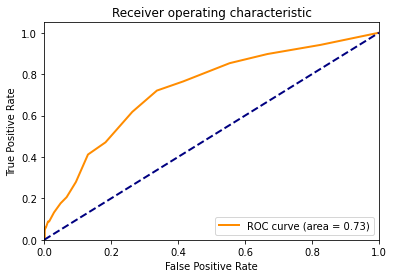

In [85]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Saving

In [ ]:
# We save these data for future plotting in one figure, for the paper

In [86]:
with open('../data_for_plotting/HBN_data/HBN_Hyp2a_y_true_df.npy', 'wb') as f:
    np.save(f, y_true_df)
with open('../data_for_plotting/HBN_data/HBN_Hyp2a_y_cbcl_df.npy', 'wb') as f:
    np.save(f, y_cbcl_df)

In [87]:
# Checking
with open('../data_for_plotting/HBN_data/HBN_Hyp2a_y_true_df.npy', 'rb') as f:
    my_true_df = np.load(f)
with open('../data_for_plotting/HBN_data/HBN_Hyp2a_y_cbcl_df.npy', 'rb') as f:
    my_cbcl_df = np.load(f)

In [88]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(my_true_df, my_cbcl_df)
roc_auc = auc(fpr, tpr)
roc_auc

0.7286380238369858

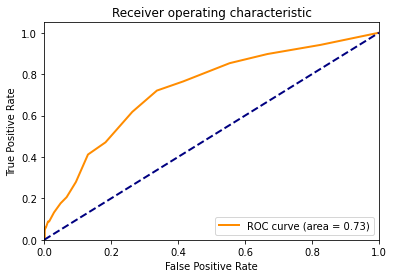

In [89]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

# Bootstrapping

In [90]:
rng = np.random.default_rng()
boot_ind = rng.choice(range(len(y_true_df)), size=y_true_df.size, replace=True)
boot_ind

array([594, 377, 433, 230, 288, 300, 272, 311, 387, 249, 148, 364,  77,
       191, 563, 134, 360, 162, 155,  75, 554, 199, 466, 605, 139, 224,
       284, 617, 224, 511, 466, 139, 200, 262, 174, 237, 290, 457,  16,
       532,  45, 285,   9, 588, 464, 467,  13, 629, 311, 106, 637, 387,
       505, 673, 556, 479, 286, 549, 402, 412, 485, 564, 118, 621, 259,
       524, 605, 107,  36, 364,  14, 264,   0, 215, 527, 365, 163, 227,
       234, 652, 278, 639, 465, 180, 433, 457, 522, 153, 199, 143, 530,
       565,  12, 340, 640, 164, 641, 628,  71, 536, 464, 626, 423, 542,
       412,  63, 197, 335, 364, 473, 101,  96, 533,  11, 528,  87, 419,
       338, 247, 285, 658, 505, 676, 530, 147, 136, 625, 151, 533, 499,
         3, 270,  88, 474, 345, 133, 347, 136,   0, 227, 398, 674, 445,
       647, 364, 212, 671, 340, 328, 321, 330,   5, 447, 478,   7, 544,
       562, 493, 299, 469, 564, 666, 337,  82, 561, 537, 624, 217, 315,
       487,  51, 458, 117, 425,  43,  23, 515, 595, 499, 209, 40

In [91]:
print(type(y_true_df))
y_true_df = y_true_df.to_frame()
y_cbcl_df = y_cbcl_df.to_frame()
print(type(y_true_df))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


In [92]:
y_true_df.head()

,gs_depression
1367,0
414,0
2151,0
2805,1
2708,0


In [93]:
boot_truth = y_true_df.iloc[boot_ind]
boot_score = y_cbcl_df.iloc[boot_ind]
print(y_cbcl_df.head(5))
print(boot_score.head(5))

      CBCL_depressed
1367              12
414                0
2151               0
2805               3
2708               6
      CBCL_depressed
1808               0
1176               1
2793               5
2067               3
157                0


In [94]:
def gen_auc_boots(scores, truth, nboots=100, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    boot_res = []
    for pp in range(nboots):
        boot_ind = rng.choice(range(len(truth)), size=truth.size, replace=True)
        boot_truth = truth.iloc[boot_ind]
        boot_score = scores.iloc[boot_ind]
        boot_res.append(roc_auc_score(boot_truth, boot_score))
    return np.array(boot_res)

In [95]:
target_auc = 0.8 # because we defined it this way. Change for Hyp 2b.

boots = gen_auc_boots(y_cbcl_df, y_true_df, nboots=1000, rng=rng)
boots = np.hstack([boots, np.array([sample_auc_score])])
p = (boots >= target_auc).mean()

In [96]:
boots

array([0.75145996, 0.7613466 , 0.72061435, ..., 0.74721668, 0.73130292,
       0.72863802])

In [97]:
min(boots)

0.6122778675282714

In [99]:
p

0.005994005994005994

In [100]:
target_auc

0.8

# RESULTS

In [102]:
p_onesided = (boots >= target_auc).mean()
p_onesided

0.005994005994005994

In [104]:
p_twosided1 = (boots > target_auc).mean()
p_twosided2 = (boots < target_auc).mean()
p_twosided = min(p_twosided1, p_twosided2)*2
p_twosided

0.011988011988011988

In [ ]:
print(np.quantile(boots, .025))
print(np.quantile(boots, .975))
boots_mean_AUCROC = np.mean(boots)
print(boots_mean_AUCROC, '(', np.quantile(boots, .025), np.quantile(boots, .975), ')')

# Confusion matrix

In [110]:
conf_fpr, conf_tpr, conf_thresh = roc_curve(y_true, y_cbcl)
conf_thresh

array([25, 24, 18, 17, 16, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,
        2,  1,  0])

In [111]:
roc_auc = auc(conf_fpr, conf_tpr)
roc_auc

0.7286380238369858

In [112]:
print(y_cbcl[:50])
print(min(y_cbcl))
print(max(y_cbcl))

[12, 0, 0, 3, 6, 11, 1, 5, 1, 3, 3, 2, 1, 2, 9, 0, 5, 1, 8, 0, 5, 4, 2, 8, 5, 8, 2, 12, 2, 7, 0, 12, 3, 1, 2, 5, 2, 3, 5, 1, 6, 4, 1, 0, 5, 6, 1, 5, 5, 4]
0
24


In [113]:
def predict_y(cbcl, threshold):
    y_score = []
    for item in y_cbcl:
        if item >= threshold:
            y_score.append(1)
        else:
            y_score.append(0)
    return y_score

In [114]:
# Create a dataframe for all data for thresholds and associated fpr, tpr, tp, tn, fp, fn

# and also euclidian distance
# --> tpr - y axis 
# --> fpr - x axis 
# We want to calculate an Euclidian distance to (0,1) for each point on the ROC curve and pick the point where that is minimized. 

## dist = sqrt((x2 - x1)^2 + (y2 - y1)^2) 
## dist = sqrt(square(x2 - x1) + square(y2 - y1)) 

# I will create the df from a list of lists

# first initiate the lists

all_roc_auc = []
all_fpr = []
all_tpr = []
all_tn = []
all_fp = []
all_fn = []
all_tp = []
all_thresholds = []
all_euclidian = []

# Point to calculate the Euclidian distance with - (0, 1)
optimal_performance = np.array((0, 1))

# now iterate through thesholds, calculate the values of interest, update the lists

for threshold in range (0,50): #51,90
    # predict diagnoses with the given threshold
    y_score = predict_y(y_cbcl, threshold)
    # calculate fp, fn, tp, tn, aucroc
    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    fpr = fp/(fp+tn)
    tpr = tp/(tp+fn)
    # calculate euclidian
    fpr_tpr_datapoint = np.array((fpr, tpr))
    sum_sq = np.sum(np.square(optimal_performance - fpr_tpr_datapoint))
    euclidian = np.sqrt(sum_sq)
    
    # update all lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_tn.append(tn)
    all_fp.append(fp)
    all_fn.append(fn)
    all_tp.append(tp)
    all_thresholds.append(threshold)
    all_euclidian.append(euclidian)


# make a dataframe out of lists

conf_matrices_data = pd.DataFrame(list(zip(all_thresholds, all_euclidian, all_fpr, all_tpr, all_tp, all_tn, all_fp, all_fn)),
               columns =['threshold', 'Euclidian', 'FPR', 'TPR', 'TP', 'TN', 'FP', 'FN'])

conf_matrices_data

,threshold,Euclidian,FPR,TPR,TP,TN,FP,FN
0,0,1.000000,1.000000,1.000000,68,0,612,0
1,1,0.827257,0.825163,0.941176,64,107,505,4
2,2,0.674568,0.666667,0.897059,61,204,408,7
3,3,0.573110,0.553922,0.852941,58,273,339,10
4,4,0.477091,0.415033,0.764706,52,358,254,16
5,5,0.437460,0.336601,0.720588,49,406,206,19
6,6,0.464113,0.263072,0.617647,42,451,161,26
7,7,0.560150,0.183007,0.470588,32,500,112,36
8,8,0.602585,0.130719,0.411765,28,532,80,40
9,9,0.726794,0.094771,0.279412,19,554,58,49


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


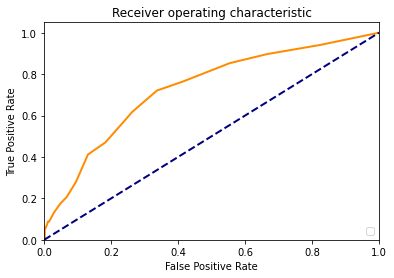

In [115]:
# Just to visualize

plt.figure()
lw = 2 # linewidt
plt.plot(
    all_fpr,
    all_tpr,
    color="darkorange",
    lw=lw,
    #label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

In [116]:
# Find the best fpr/tpr pair

# What is the min euclidian distance in the dataframe?
conf_matrices_data[['Euclidian']].idxmin()

Euclidian    5
dtype: int64

In [117]:
# change the index manually
conf_matrices_data.loc[5]

threshold      5.000000
Euclidian      0.437460
FPR            0.336601
TPR            0.720588
TP            49.000000
TN           406.000000
FP           206.000000
FN            19.000000
Name: 5, dtype: float64